### Experiment Notebook

This notebook integrates the separate components to form the experiment. 

In [1]:
import torch
import torch.nn.utils.prune as prune
from torch_cka import CKA
import datasets
import transformers
import numpy as np
import matplotlib.pyplot as plt
import os
import copy

from torch.utils.data import DataLoader
from bertviz import model_view, head_view

# Local
import sys
sys.path.append('..')
from src.load_bert import load_all, load_config_and_tokenizer, load_model

/home/andrew/.pyenv/versions/3.10.2/envs/bertenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Encode various tasks
def preprocess_cola(examples, tokenizer, max_len):
    return tokenizer(examples['sentence'], padding='max_length', max_length=max_len)

def preprocess_sst2(examples, tokenizer):
    return tokenizer(examples['sentence'], padding='max_length')

def preprocess_qqp(examples, tokenizer):
    return tokenizer(examples["question1"], examples["question2"], padding="max_length", truncation=True)

def preprocess_rte(examples, tokenizer):
    return tokenizer(examples["sentence1"], examples["sentence2"], padding="max_length", truncation=True)

def encodeTask(task, tokenizer, batch_size):

    # Setup chosen task and metric
    dataset = datasets.load_dataset("glue", task)
    metric = datasets.load_metric("glue", task, trust_remote_code=True)

    # Cola pads to make length so all inputs are equal 
    if(task == 'cola'):
        # Figure out dataset characteristics
        max_len_train = len(max(dataset['train']['sentence'][:]))
        max_len_val = len(max(dataset['validation']['sentence'][:]))
        max_len_test = len(max(dataset['test']['sentence'][:]))
        max_len = max(max_len_train, max_len_val, max_len_test)

    # Tokenize Dataset
    #tokenizer = transformers.BertTokenizer.from_pretrained(checkpoint, use_fast=True)

    # Select correct preprocessing function for each task
    if(task == 'cola'):
        encoded_dataset = dataset.map(preprocess_cola, batched=True, \
                                      fn_kwargs={'tokenizer': tokenizer, 'max_len': max_len})
        tokenized_dataset = encoded_dataset.with_format('torch', columns=['input_ids', 'token_type_ids', 'attention_mask'])
    elif(task == 'rte'):
        encoded_dataset = dataset.map(preprocess_rte, batched=True, \
                                      fn_kwargs={'tokenizer': tokenizer})
        tokenized_dataset = encoded_dataset.with_format('torch', columns=['input_ids', 'attention_mask'])
    elif(task == 'sst2'):
        encoded_dataset = dataset.map(preprocess_sst2, batched=True, \
                                      fn_kwargs={'tokenizer': tokenizer})
        tokenized_dataset = encoded_dataset.with_format('torch', columns=['input_ids', 'attention_mask'])
    elif(task == 'qqp'):
        encoded_dataset = dataset.map(preprocess_qqp, batched=True, \
                                      fn_kwargs={'tokenizer': tokenizer})
        tokenized_dataset = encoded_dataset.with_format('torch', columns=['input_ids', 'attention_mask'])
    else:
        print(f"The task: {task} isn't supported by our codebase currently. Please select \
                from cola, rte, sst2, and qqp")

    num_workers = 8
    train_loader = DataLoader(tokenized_dataset['train'], batch_size=batch_size, num_workers=num_workers)
    val_loader = DataLoader(tokenized_dataset['validation'], batch_size=batch_size, num_workers=num_workers)
    test_loader = DataLoader(tokenized_dataset['test'], batch_size=1, num_workers=num_workers) # Inference uses batch size 1

    return train_loader, val_loader, test_loader

In [3]:
# Same for all tasks
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # Check for device

# Get model directory
current_dir = os.getcwd() #This is assuming that your python notebook is in the notebooks/ directory
root_dir = os.path.dirname(current_dir) 
model_dir = os.path.join(root_dir, "models")

#model_name = "bert_finetuned_CoLa"
model_name = "bert_finetuned_sst2"
#model_name = "bert_finetuned_mcq"
#model_name = "bert_finetuned_qqp"
model_directory = os.path.join(model_dir, model_name)

# Choose task (manual for now)
# COLA
#task_type = 'sequence_classification'
#num_classes = 2
#batch_size = 16

# QQP
#task_type = 'sequence_classification'
#num_classes = 4
#batch_size = 4

# SST2
task_type = 'sequence_classification'
num_classes = 2
batch_size = 4

# MCQ
#task_type = 'multiple_choice'
#num_classes = 4
#batch_size = 16

# Load in state from disk
baseline_model, baseline_config, baseline_tokenizer = load_all(model_directory, num_classes, task_type)

#model1 = model1.to(device)
#model2 = model2.to(device)

# Generate dataloaders
task = "sst2"
train_loader, val_loader, test_loader = encodeTask(task, baseline_tokenizer, batch_size)

/tmp/ipykernel_635599/3384345498.py:18: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = datasets.load_metric("glue", task, trust_remote_code=True)


In [4]:
# Calculate sparisty of the network
def calcSparsity(model):
    zeros = 0
    elements = 0

    for name, param in model.named_parameters():

        zero_count = torch.sum(param==0.0).item()
        zeros += zero_count

        element_count = param.numel()
        elements += element_count

    if(elements == 0):
        return 0

    return zeros / elements

# Note: The pruning strength is for the subset of the neurons that you want to prune (defined by the paramater list created in the build parameter list function #
def buildParameterList(model):
    parameters_to_prune = []
    parameter_names = []
    for name, module in model.named_modules():
        # Linear: Includes linear layers in attention head as well
        if isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))
    return parameters_to_prune, parameter_names

# NOTE: Metric is defined globally
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1) # TODO: switch to torch?
    #return metric.compute(predictions=predictions, references=labels)

def evaluateUnstructuredPruningOnBert(baseline_model, pruning_strength=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], num_labels=2):

    pruning_results = []
    models = []

    # Try different pruning methods
    for p_strength in pruning_strength:

        # DeepCopy Original Model
        model = copy.deepcopy(baseline_model)
        # Don't move onto GPU because of VRAM concerns

        # Choose layers to prune
        pruning_params, _ = buildParameterList(model)

        if(p_strength > 0):

            # Perform global unstrcutured pruning
            prune.global_unstructured(
                pruning_params,
                pruning_method=prune.L1Unstructured,
                amount=p_strength
            )

            # Make pruning permenant
            for module,name in pruning_params:
                prune.remove(module, name)

        models.append(model)

        sparsity = calcSparsity(model)
        print(f"Pruning strength: {p_strength}, Sparsity: {sparsity}")

        # TODO: Evaluate Model
        # Create evaluator
        #evaluator = buildTrainer(test_model, dataset, tokenizer)
        # Evaluate performance on BERT 
        #results = evaluator.evaluate()
        #metric_res = results['eval_matthews_correlation']
        #pruning_results.append((sparsity, metric_res))
        
    return pruning_results, models

In [5]:
# This needs ~ 16GB of RAM, probably best to do it on the CPU since it isn't computationally expensive
p_res, models = evaluateUnstructuredPruningOnBert(baseline_model)

Pruning strength: 0, Sparsity: 5.776281764256659e-06
Pruning strength: 0.1, Sparsity: 0.0819637083587528
Pruning strength: 0.2, Sparsity: 0.16392163291454112
Pruning strength: 0.3, Sparsity: 0.24587956499152966
Pruning strength: 0.4, Sparsity: 0.327837489547318
Pruning strength: 0.5, Sparsity: 0.40979542162430654
Pruning strength: 0.6, Sparsity: 0.4917533537012951
Pruning strength: 0.7, Sparsity: 0.5737112782570833
Pruning strength: 0.8, Sparsity: 0.6556692103340719
Pruning strength: 0.9, Sparsity: 0.7376271348898602


/home/andrew/school/grad/spring24/bert_pruning/PyTorch-Model-Compare/torch_cka/cka.py:145: UserWarning: Dataloader for Model 2 is not given. Using the same dataloader for both models.
  warn("Dataloader for Model 2 is not given. Using the same dataloader for both models.")
| Comparing features |: 100%|██████████| 218/218 [00:43<00:00,  5.07it/s]
| Comparing features |: 100%|██████████| 218/218 [00:42<00:00,  5.12it/s]
| Comparing features |:   0%|          | 1/218 [00:00<00:47,  4.60it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 48.00 MiB. GPU 

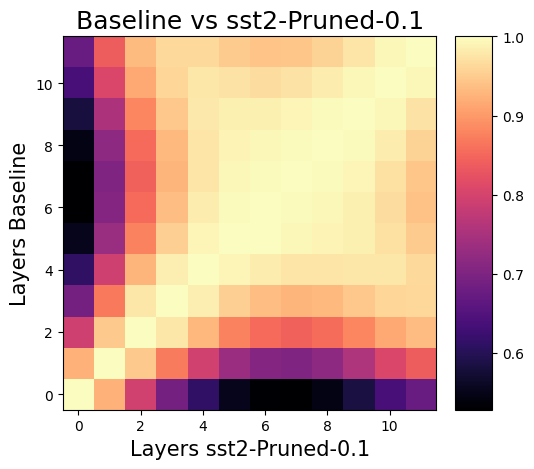

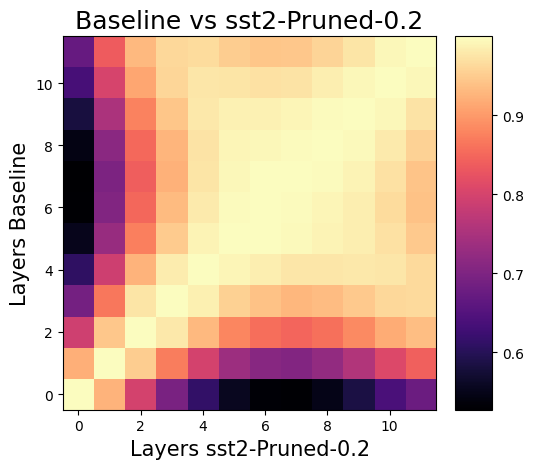

In [6]:
# Perform CKA Analysis on Pruned Models

device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # Check for device
pruning_strength=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # Eventually define above

# Create Plot Directory
root_dir = os.path.dirname( os.getcwd() )
plot_dir = os.path.join(root_dir, 'plots')

# Create plot dir if it doesn't already exist
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

dirs = os.listdir(plot_dir)

if(dirs is None):
    curr_dir = os.path.join(plot_dir, "CKA_Run1")
else:
    curr_dir = os.path.join(plot_dir, f"CKA_Run{len(dirs)}")

# Create plot directory 
os.mkdir(curr_dir)

# Choose layers to factor into CKA calculation
model1_names = [f"bert.encoder.layer.{i}.attention" for i in range(0, 12)]
model2_names = [s for s in model1_names] # Perform Copy

length = len(models)

# Always compare against baseline
# Be careful to watch VRAM when running this
for i in range(1, length):

    with torch.no_grad():
        model1_name = "Baseline"
        model2_name = f"{task}-Pruned-{pruning_strength[i]}"

        model1 = models[0] # Baseline
        model2 = models[i] # Pruned Model

        model1 = model1.to(device)
        model2 = model2.to(device)

        cka = CKA(model1, model2, model1_name=model1_name, model2_name=model2_name, model1_layers=model1_names, model2_layers=model2_names, device=device)
        cka.compare(val_loader) # Maybe use a different dataloader?
        results = cka.export()

        #print(results)
        plot_name = os.path.join(curr_dir, f"{task}_" + model2_name + ".png")
        cka.plot_results(plot_name, f"{model1_name} vs {model2_name}")

        # Remove model from GPU mem
        del model2 # Reference therefore list idx deleted as well
        torch.cuda.empty_cache()

In [ ]:
### Unused / Extra Code
"""
def encodeRTE():

    task = "rte"
    dataset = datasets.load_dataset("glue", task)
    metric = datasets.load_metric("glue", task, trust_remote_code=True)

    tokenizer = transformers.BertTokenizer.from_pretrained(checkpoint)
    def preprocess_function(examples):
        return tokenizer(examples["sentence1"], examples["sentence2"], padding="max_length", truncation=True)

    encoded_dataset = dataset.map(preprocess_function, batched=True)
    encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    RTE_train_dataset = encoded_dataset['train']
    RTE_validation_dataset = encoded_dataset['validation']
    RTE_train_dataloader = DataLoader(RTE_train_dataset, shuffle=True, batch_size=batch_size)
    RTE_validation_dataloader = DataLoader(RTE_validation_dataset, batch_size=batch_size)
"""


"""
def encodeSST():

    # Setup chosen task and metric
    task = "sst2"
    checkpoint = "bert-base-uncased" # TODO: Update this
    dataset = datasets.load_dataset("glue", task)
    metric = datasets.load_metric("glue", task, trust_remote_code=True)

    # Tokenize Dataset
    tokenizer = transformers.BertTokenizer.from_pretrained(checkpoint, use_fast=True)

    def preprocess_function(examples):
        return tokenizer(examples["sentence"], padding="max_length", truncation=True)

    encoded_dataset = dataset.map(preprocess_function, batched=True)
    encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    # SST dataloaders 
    batch_size = 16
    train_dataset = encoded_dataset['train']
    validation_dataset = encoded_dataset['validation']
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)
"""

"""
def encodeCola():

    # Setup chosen task and metric
    task = "cola"
    checkpoint = "bert-base-uncased" #TODO: Update this to local fine tuned model
    dataset = datasets.load_dataset("glue", task)
    metric = datasets.load_metric("glue", task)

    # Figure out dataset characteristics
    max_len_train = len(max(dataset['train']['sentence'][:]))
    max_len_val = len(max(dataset['validation']['sentence'][:]))
    max_len_test = len(max(dataset['test']['sentence'][:]))
    max_len = max(max_len_train, max_len_val, max_len_test)

    # Tokenize Dataset
    tokenizer = transformers.BertTokenizer.from_pretrained(checkpoint, use_fast=True)
    # preprocess function
    def preprocess_function(examples):
        return tokenizer(examples['sentence'], padding='max_length', max_length=max_len)
    encoded_dataset = dataset.map(preprocess_function, batched=True)

    return task, metric, encoded_dataset, tokenizer
"""

"""
def encodeQQP():

    task = "qqp"  
    checkpoint = "bert-base-uncased"
    batch_size = 16

    dataset = datasets.load_dataset("glue", task)
    metric = datasets.load_metric("glue", task, )

    def preprocess_function(examples):
        return tokenizer(examples["question1"], examples["question2"], padding="max_length", truncation=True)

    tokenizer = transformers.BertTokenizer.from_pretrained(checkpoint)
    encoded_dataset = dataset.map(preprocess_function, batched=True)
    encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    encoded_dataset['train'] = encoded_dataset['train'].select(range(67349))
    train_dataset = encoded_dataset['train']
    validation_dataset = encoded_dataset['validation']
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size)
"""